In [497]:
seed = 1024
import numpy as np
np.random.seed(seed)

In [498]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.image import imread


In [499]:
STDir = "/projects/li-lab/Yue/DataPool/Spatial/ST-Net/data/hist2tscript"
resultDir = '/projects/li-lab/Yue/SpatialAnalysis/output'

import sys
sys.path.insert(1, '/projects/li-lab/Yue/SpatialAnalysis/py') ##~wont work, has to start with /Users
import ensembl #from st-net

In [500]:
def read_st_net_data(
    i
) -> sc.AnnData:
    """\
    Read 10x-Genomics-formatted visum dataset.
    In addition to reading regular 10x output,
    this looks for the `spatial` folder and loads images,
    coordinates and scale factors.
    Based on the `Space Ranger output docs`_.
    See :func:`~scanpy.pl.spatial` for a compatible plotting function.
    .. _Space Ranger output docs: https://support.10xgenomics.com/spatial-gene-expression/software/pipelines/latest/output/overview
    Parameters
    ----------
    path
        Path to directory for visium datafiles.
    genome
        Filter expression to genes within this genome.
    count_file
        Which file in the passed directory to use as the count file. Typically would be one of:
        'filtered_feature_bc_matrix.h5' or 'raw_feature_bc_matrix.h5'.
    library_id
        Identifier for the visium library. Can be modified when concatenating multiple adata objects.
    source_image_path
        Path to the high-resolution tissue image. Path will be included in
        `.uns["spatial"][library_id]["metadata"]["source_image_path"]`.
    Returns
    -------
    Annotated data matrix, where observations/cells are named by their
    barcode and variables/genes by gene name. Stores the following information:
    :attr:`~anndata.AnnData.X`
        The data matrix is stored
    :attr:`~anndata.AnnData.obs_names`
        Cell names
    :attr:`~anndata.AnnData.var_names`
        Gene names for a feature barcode matrix, probe names for a probe bc matrix
    :attr:`~anndata.AnnData.var`\\ `['gene_ids']`
        Gene IDs
    :attr:`~anndata.AnnData.var`\\ `['feature_types']`
        Feature types
    :attr:`~anndata.AnnData.obs`\\ `[filtered_barcodes]`
        filtered barcodes if present in the matrix
    :attr:`~anndata.AnnData.var`
        Any additional metadata present in /matrix/features is read in.
    :attr:`~anndata.AnnData.uns`\\ `['spatial']`
        Dict of spaceranger output files with 'library_id' as key
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['images']`
        Dict of images (`'hires'` and `'lowres'`)
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['scalefactors']`
        Scale factors for the spots
    :attr:`~anndata.AnnData.uns`\\ `['spatial'][library_id]['metadata']`
        Files metadata: 'chemistry_description', 'software_version', 'source_image_path'
    :attr:`~anndata.AnnData.obsm`\\ `['spatial']`
        Spatial spot coordinates, usable as `basis` by :func:`~scanpy.pl.embedding`.
    """
    
    STDir = "/projects/li-lab/Yue/DataPool/Spatial/ST-Net/data/hist2tscript"
    
    df_meta = pd.read_csv(STDir+'/metadata.csv')
    library_id = df_meta.patient[i]+'_'+df_meta.replicate[i]
    print(library_id)
    print(df_meta.iloc[i])
    

    # read json scalefactors
    #adata.uns["spatial"][library_id]['scalefactors'] = json.loads(
    #    files['scalefactors_json_file'].read_bytes()
    #)

    #adata.uns["spatial"][library_id]["metadata"] = {
    #    k: (str(attrs[k], "utf-8") if isinstance(attrs[k], bytes) else attrs[k])
    #    for k in ("chemistry_description", "software_version")
    #    if k in attrs
    #}

    # read coordinates
    
    coords_csv = STDir+ '/' + df_meta.spot_coordinates[i]
    positions = pd.read_csv(coords_csv, index_col = 0)
    #print(positions)
    
    coords_csv = STDir+ '/' + df_meta.tumor_annotation[i]
    spot_df = pd.read_csv(coords_csv, index_col = False, sep = '\t')
    spot_df.columns = ['id','xcoord', 'ycoord', 'lab', 'tumor']

    spot_df['id'] = spot_df.xcoord.astype('str') + 'x' + spot_df.ycoord.astype('str')
    spot_df.index = spot_df['id']
    #print(spot_df)
    


    st_csv = STDir+ '/' + df_meta.count_matrix[i]
    st_exp_df = pd.read_csv(st_csv, index_col = 0, sep = '\t')
    #print(st_exp_df)
    #adata.obs = positions
    positions = positions.join(spot_df, how="left")
    positions['in_tissue'] = 1

    positions.columns = [
        'pxl_row_in_fullres',
        'pxl_col_in_fullres',
        'id',
        'array_row',
        'array_col',
        'lab',
        'tumor',
        'in_tissue',
        
        
    ]
    
    st_exp_df = st_exp_df.reindex(list(positions.index))
    #positions = positions.reindex(list(st_exp_df.index))
    
    
    gene_names = list(map(lambda x: ensembl.symbol[x], st_exp_df.columns))
    st_exp_df.columns = gene_names
    
    var_df = pd.DataFrame(st_exp_df.columns)
    var_df.index = st_exp_df.columns
    
    print(positions.head())
    print(var_df.head())
    print(st_exp_df.head())
    
    adata = sc.AnnData(X = st_exp_df,
                       obs = positions,
                       var = var_df)
    adata.uns["spatial"] = dict()

    adata.uns["spatial"][library_id] = dict()

    tissue_positions_file = STDir + '/' + df_meta.spot_coordinates[i]

    # check if files exists, continue if images are missing

    adata.uns["spatial"][library_id]['images'] = dict()
    for res in ['hires']:
        try:
            adata.uns["spatial"][library_id]['images'][res] = imread(
                str(STDir+ '/' + df_meta.histology_image[i])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")
    
    
    adata.obsm['spatial'] = adata.obs[
        ['pxl_row_in_fullres', 'pxl_col_in_fullres']
    ].to_numpy()
#     adata.obs.drop(
#         columns=['pxl_row_in_fullres', 'pxl_col_in_fullres'],
#         inplace=True,
#     )

    # put image path in uns
#     if source_image_path is not None:
#         # get an absolute path
#         source_image_path = str(Path(source_image_path).resolve())
#         adata.uns["spatial"][library_id]["metadata"]["source_image_path"] = str(
#             source_image_path
#         )

    return adata

In [501]:
#HE_BT23903_C2.jpg  HE_BT23450_E1.jpg
df_meta = pd.read_csv(STDir+'/metadata.csv')
#idx = df_meta.histology_image[df_meta.histology_image == 'HE_BT23903_C2.jpg'].index[0]

#patient_id = 'BC23903'
#patient_id = 'BC23450'
patient_id = 'BC23287'


rep_id = 'C2' #C1 C2
idx = df_meta.loc[(df_meta.patient == patient_id) & (df_meta.replicate == rep_id),:].index[0]


library_id = patient_id + '_' + rep_id
df_prediction = pd.read_csv('pretrained_ViT_cv_prediction.csv',index_col = 0)
#df_prediction = pd.read_csv('scratch_ViT_cv_prediction.csv',index_col = 0)

df_index = pd.Series(df_prediction.index).str.split('_', expand = True)
df_index.columns = ['patient','rep','coords']
df_index.index = df_prediction.index
df_prediction_sub = df_prediction.loc[(df_index.patient == patient_id) & (df_index.rep == rep_id),:]
df_prediction_sub.index = df_index.loc[df_prediction_sub.index,:].coords

In [502]:
df_prediction

,RPS3,IGLL5,RPLP1,TFF3,TMSB10,RPS18,GAPDH,RPLP2,RPL37A,RPS14,...,COX4I1,PFDN5,SPARC,ISG15,EIF5A,__ambiguous[ENSG00000177576+ENSG00000265681+ENSG00000215472],FXYD3,UBE2M,COL6A2,CHCHD2
BC23209_C1_3x21,2.062522,2.274657,2.842162,1.187566,2.662145,2.622372,2.632204,2.668511,2.408814,2.540340,...,0.845686,0.965369,0.937453,0.762935,0.824928,0.720153,0.811344,0.843668,1.014394,0.807160
BC23209_C1_12x20,1.768138,1.934129,2.566688,0.976563,2.298852,2.336301,2.290283,2.385177,2.111347,2.264787,...,0.665471,0.838176,0.805259,0.602903,0.651542,0.522707,0.636163,0.658385,0.935462,0.630985
BC23209_C1_5x19,2.271520,2.544707,3.014832,1.348295,2.894584,2.813072,2.871415,2.853445,2.611366,2.731189,...,0.983141,1.048007,1.001340,0.878562,0.967695,0.882054,0.926810,0.991329,1.027601,0.939237
BC23209_C1_6x13,2.065521,2.278759,2.849176,1.195151,2.670927,2.630605,2.638264,2.682567,2.415136,2.549741,...,0.847903,0.969501,0.950888,0.766254,0.826655,0.720045,0.813897,0.848432,1.025962,0.810000
BC23209_C1_6x24,2.263592,2.530789,3.023217,1.335992,2.894770,2.813317,2.868857,2.856628,2.608024,2.732282,...,0.973982,1.045008,1.005824,0.870546,0.955063,0.867036,0.919798,0.981170,1.038826,0.930588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC24105_C1_26x22,2.326582,2.365524,2.902099,1.328523,2.706175,2.752273,2.771850,2.739434,2.632567,2.572030,...,0.986372,0.956958,0.846073,0.853484,1.008501,1.019639,0.882667,1.031574,0.810021,1.007488
BC24105_C1_26x23,2.394181,1.858869,2.856796,1.138600,2.468095,2.719614,2.689855,2.631581,2.732804,2.369947,...,0.960149,0.798688,0.772569,0.692933,1.019400,1.191234,0.709520,0.966725,0.702716,1.119666
BC24105_C1_8x28,2.121711,1.156165,2.551018,0.720144,2.057019,2.400075,2.362237,2.306545,2.517608,1.936967,...,0.792095,0.566741,0.750401,0.485151,0.840030,1.096229,0.458778,0.728201,0.691799,1.082010
BC24105_C1_8x25,2.093934,1.142654,2.528459,0.693217,2.039178,2.386953,2.348109,2.286099,2.499608,1.910037,...,0.784582,0.562033,0.760417,0.479520,0.826916,1.077081,0.445903,0.714179,0.712358,1.075286


In [503]:
df_prediction_sub.columns = df_prediction_sub.columns + '_pred'
#df_prediction_sub = (df_prediction_sub - df_prediction_sub.mean())/df_prediction_sub.std()
df_prediction_sub

,RPS3_pred,IGLL5_pred,RPLP1_pred,TFF3_pred,TMSB10_pred,RPS18_pred,GAPDH_pred,RPLP2_pred,RPL37A_pred,RPS14_pred,...,COX4I1_pred,PFDN5_pred,SPARC_pred,ISG15_pred,EIF5A_pred,__ambiguous[ENSG00000177576+ENSG00000265681+ENSG00000215472]_pred,FXYD3_pred,UBE2M_pred,COL6A2_pred,CHCHD2_pred
coords,,,,,,,,,,,,,,,,,,,,,
7x16,1.561284,1.748119,2.265314,0.790651,1.983364,2.034666,1.992377,2.092112,1.834047,1.934662,...,0.573186,0.704038,0.666126,0.510604,0.545913,0.450761,0.507469,0.553966,0.800622,0.542944
4x14,1.561580,1.748518,2.265743,0.790779,1.983814,2.035062,1.992764,2.092533,1.834418,1.935105,...,0.573268,0.704207,0.666335,0.510719,0.546026,0.450761,0.507613,0.554040,0.800868,0.543022
5x15,1.564957,1.752612,2.270572,0.792775,1.988744,2.039507,1.997090,2.097182,1.838411,1.939580,...,0.574448,0.705833,0.668423,0.512163,0.547378,0.451488,0.509370,0.555541,0.803079,0.544002
4x13,1.562580,1.749709,2.267073,0.791391,1.985187,2.036315,1.994030,2.093809,1.835574,1.936312,...,0.573686,0.704653,0.666878,0.511146,0.546504,0.451165,0.508161,0.554551,0.801417,0.543427
8x19,1.562806,1.750136,2.267631,0.791518,1.985661,2.036805,1.994393,2.094415,1.835913,1.936813,...,0.573666,0.704819,0.667110,0.511259,0.546488,0.450954,0.508187,0.554607,0.801754,0.543353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21x31,2.319587,2.115218,2.850107,0.970180,2.460660,2.640563,2.733375,2.618298,2.655633,2.352972,...,0.936307,0.690928,0.825484,0.656361,0.970608,1.180080,0.625070,0.893006,0.703848,1.130711
23x28,2.476750,2.699751,3.086383,1.307324,2.914170,2.913756,3.006458,2.910540,2.770647,2.731619,...,1.094685,0.984127,0.917079,0.925277,1.089336,1.126511,0.923585,1.089707,0.852611,1.097409
20x26,2.482722,2.543224,3.051354,1.214595,2.779873,2.862745,2.952681,2.856799,2.781430,2.641522,...,1.066386,0.882086,0.874588,0.838904,1.076647,1.192578,0.824726,1.056757,0.775484,1.135615


In [504]:
gene_predict = 'DDX5'
#gene_predict = 'ACTG1'
#gene_predict = 'GNAS'

adata = read_st_net_data(idx)
sc.pp.scale(adata)

BC23287_C2
type                            HER2_luminal
patient                              BC23287
replicate                                 C2
count_matrix        BC23287_C2_stdata.tsv.gz
histology_image            HE_BT23287_C2.jpg
spot_coordinates     spots_BT23287_C2.csv.gz
tumor_annotation    BC23287_C2_Coords.tsv.gz
Name: 1, dtype: object
       pxl_row_in_fullres  pxl_col_in_fullres     id  array_row  array_col  \
6x13             1425.832            3470.988   6x13          6         13   
7x13             1724.341            3473.203   7x13          7         13   
15x13            4051.107            3470.640  15x13         15         13   
16x13            4348.925            3473.118  16x13         16         13   
5x13             1137.994            3475.730   5x13          5         13   

      lab tumor  in_tissue  
6x13   L1   non          1  
7x13   L2   non          1  
15x13  L3   non          1  
16x13  L4   non          1  
5x13   L5   non          1  
        

/tmp/ipykernel_143081/399338450.py:125: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X = st_exp_df,
/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (91985625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [505]:
gene_predict in list(df_prediction.columns)

True

In [506]:
# plt.hist(np.log(adata.X[:,adata.var.index == gene_predict]+1))
#adata.X[:,adata.var.index == gene_predict]
# #plt.hist(df_prediction_sub[gp])
# d = df_prediction_sub[gp]
# d = np.exp(d)
# d = (d - d.mean())/d.std()
# print(np.mean(d))
# print(np.var(d))
# plt.hist(d)
# print(np.var(adata.obs[gp]))

In [507]:
#############prediction
gp = gene_predict+'_pred'

df_prediction_sub[gp] = np.exp(df_prediction_sub[gp]) ###exp since prediction is log(x+1)
#adata.obs[gp].fillna(0, inplace = True)
df_prediction_sub[gp] = (df_prediction_sub[gp] - df_prediction_sub[gp].mean())/df_prediction_sub[gp].std()

print(np.mean(df_prediction_sub[gp]))
print(np.var(df_prediction_sub[gp]))
adata.obs = adata.obs.join(df_prediction_sub[gp])
#adata.obs[gp].fillna(0, inplace = True)


4.254746920719163e-17
0.9970059880239521


/tmp/ipykernel_143081/262644221.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_sub[gp] = np.exp(df_prediction_sub[gp]) ###exp since prediction is log(x+1)
/tmp/ipykernel_143081/262644221.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prediction_sub[gp] = (df_prediction_sub[gp] - df_prediction_sub[gp].mean())/df_prediction_sub[gp].std()


In [508]:
img_shape = adata.uns["spatial"][library_id]['images']['hires'].shape

0.5883378461327443


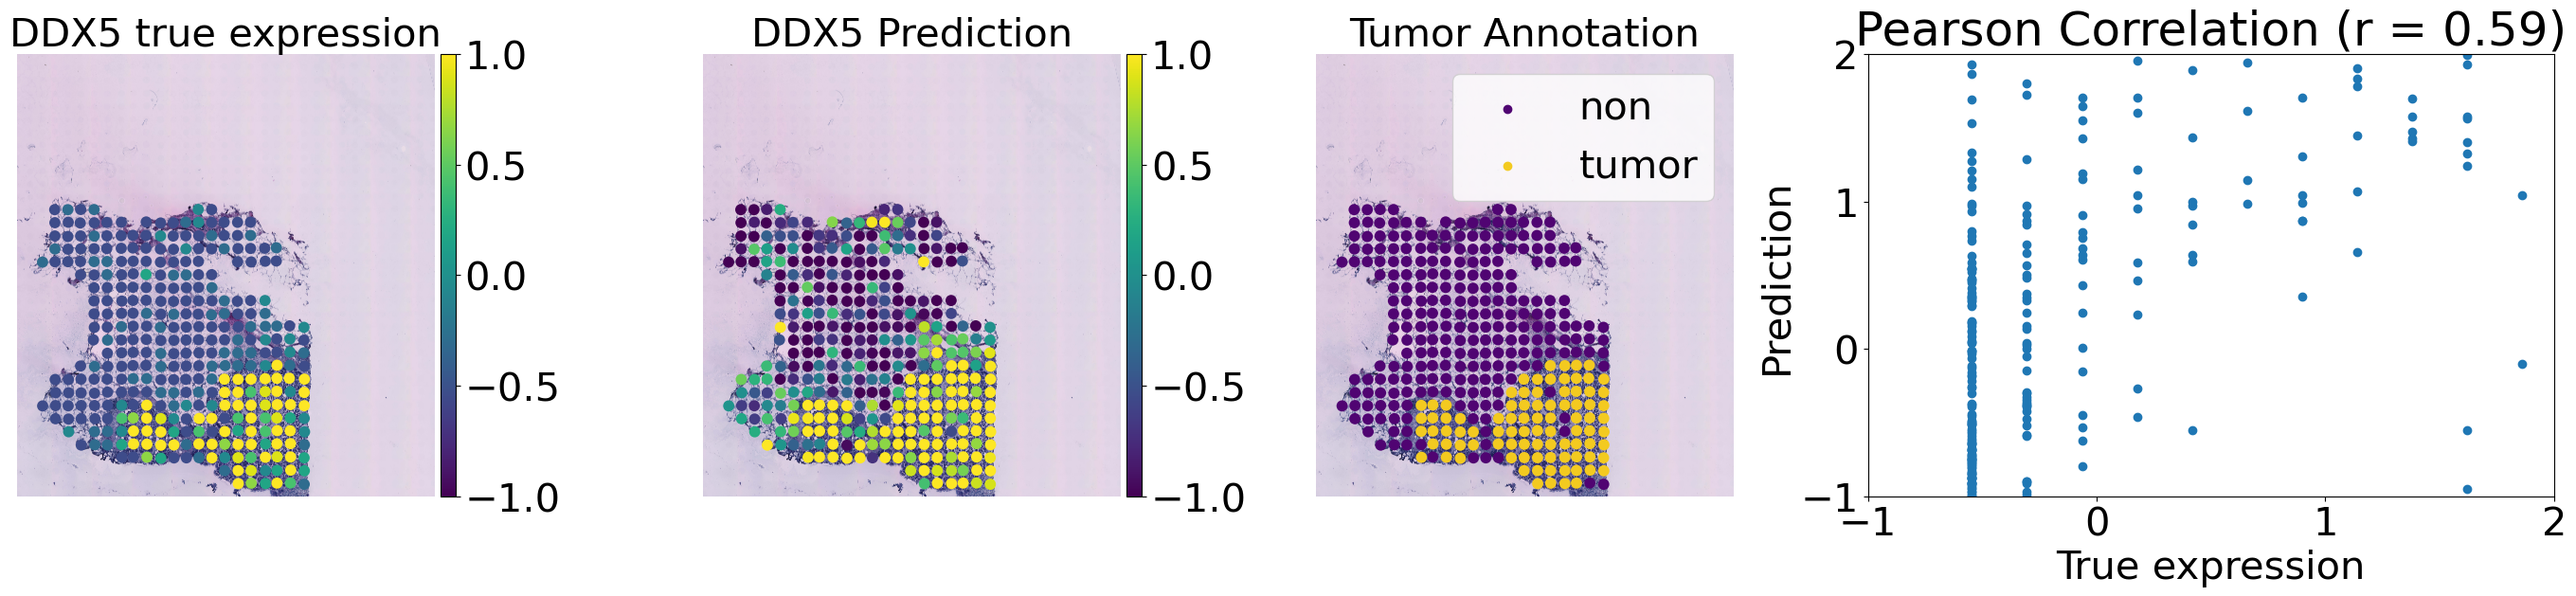

In [509]:
fig, axs = plt.subplots(ncols=4, figsize=(30, 7))
font_size = 30
plt.rcParams.update({'font.size': font_size})


#plt.title('Tumor', fontsize = font_size)
sc.pl.spatial(adata, img_key = "hires", color='tumor',
              size=1, spot_size = 250, scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              na_in_legend = False,
              #return_fig = True,
              ax = axs[2],
              title = 'Tumor',
              palette = ('#500472', '#f3ca20'),
              #save = 'pretrained_'+ library_id + '_tumor.pdf',
              legend_fontsize = font_size,
              show = False,
              #legend_loc = 'on data'
              #alpha = 0.8
              #vmin = ,vmax = 2
             )

#fig, ax = plt.subplots()

ax = sc.pl.spatial(adata, img_key = "hires", color=gp,
              size=1, spot_size = 250, scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              title = gene_predict+' Prediction',
              vmin = -1,vmax = 1,
              na_in_legend = False,
              return_fig = True,
              ax = axs[1],
              show = False,
              #save = 'pretrained_'+ library_id + '_'+gene_predict+ '_prediction'+'.pdf',
              #colorbar_loc = 'bottom'
             )


#fig, ax = plt.subplots()


sc.pl.spatial(adata, img_key = "hires", color=gene_predict,
              size=1, spot_size = 250, scale_factor = 1,
              crop_coord=[0, img_shape[1], 0, img_shape[0]],
              vmin = -1, vmax = 1,
              na_in_legend = False,
              return_fig = True,
              ax = axs[0],
              show = False,
              title = gene_predict+' true expression',
              #colorbar_loc = 'bottom'
              #save = 'pretrained_'+ library_id + '_'+gene_predict+ '_prediction'+'.pdf'
   
             )
ax4 = axs[3]
x = np.array(adata.X[:,adata.var.index == gene_predict])
x = (x - x.mean())/x.std()
x = x.flatten()

y = np.array(adata.obs[gp]).flatten()

xy = np.vstack([x.flatten(), y.flatten()])
#density = np.log(np.histogram2d(xy[0], xy[1], bins=50, density=True)[0])
#pcm = ax4.imshow(density, cmap='plasma', origin='lower', aspect='1', extent=[x.min(), x.max(), y.min(), y.max()])
#pcm = ax4.hist2d(x, y, bins=(50, 50), cmap=plt.cm.Greys)
ax4.plot(x,y, linestyle='none', marker='o')
ax4.set_xlim(-1,2)
ax4.set_ylim(-1,2)
#plt.colorbar(pcm, label='Density', pad=0.04, fraction=0.046, cax = ax4)  # Add a colorbar and adjust its position
# Calculate the correlation coefficient
correlation_coefficient = np.corrcoef(x.flatten(), y.flatten())[0, 1]
print(correlation_coefficient)
# plt.text(0.02, 0.93, f'r = {correlation_coefficient:.2f}',
#          transform=plt.gca().transAxes, fontsize=18, bbox=dict(facecolor='white', alpha=0.8))
ax4.set_xlabel("True expression", fontsize = font_size)
ax4.set_ylabel("Prediction",fontsize = font_size)
ax4.set_title(f"Pearson Correlation (r = {correlation_coefficient:.2f})")

    

titles = [
            gene_predict+' true expression',
            gene_predict+' Prediction',
            'Tumor Annotation',
            'Tumor Annotation vs Prediction'
         ]
for i in range(4):
    if i == 3:
        continue
    else:
        fig.axes[i].set_axis_off()
        
    fig.axes[i].set_title(titles[i], fontdict={'fontsize': font_size, 'fontweight': 'medium'})
    

    
fig.axes[-2].tick_params(labelsize=font_size) 
fig.axes[-1].tick_params(labelsize=font_size) 
fig.axes[2].legend(loc= 'upper right')

plt.tight_layout()
plt.subplots_adjust(hspace = 0, wspace = 0)
plt.savefig(resultDir+'/pretrained_'+ library_id + '_'+gene_predict+ '_aggregate'+'.pdf',
            bbox_inches='tight')

In [510]:
plt.show()

In [511]:
adata.X[:,adata.var.index == gene_predict]

array([[-0.54442155],
       [-0.30421442],
       [-0.06400729],
       [-0.54442155],
       [-0.30421442],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.30421442],
       [-0.06400729],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.30421442],
       [-0.30421442],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.06400729],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.30421442],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.30421442],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0

In [512]:
adata.obs[gp]

6x13    -0.852307
7x13     0.247444
15x13   -0.794556
16x13   -0.689078
5x13    -1.146688
           ...   
19x34    0.985242
21x34    1.212698
20x34    1.599619
18x34    0.399107
23x34    0.869064
Name: DDX5_pred, Length: 334, dtype: float64

In [513]:
df_prediction_sub[gp]

coords
7x16    -1.210386
4x14    -1.210441
5x15    -1.208863
4x13    -1.209511
8x19    -1.210166
           ...   
21x31    1.410721
23x28    1.468227
20x26    1.684898
22x29    1.041730
23x29    1.643343
Name: DDX5_pred, Length: 334, dtype: float64

In [514]:
adata.obs['is_tumor'] = 0
adata.obs['is_tumor'].loc[adata.obs['tumor'] == 'tumor'] = 1
adata.obs[gp] = adata.obs[gp].fillna(0)
np.corrcoef(adata.obs[gp],adata.obs['is_tumor'])


/tmp/ipykernel_143081/4182595116.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['is_tumor'].loc[adata.obs['tumor'] == 'tumor'] = 1


array([[1.        , 0.73179316],
       [0.73179316, 1.        ]])

In [515]:
np.corrcoef(adata.obs['is_tumor'], adata.X[:,adata.var.index == gene_predict].flatten())


array([[1.        , 0.74335215],
       [0.74335215, 1.        ]])

In [516]:
np.corrcoef(adata.obs[gp],adata.X[:,adata.var.index == gene_predict].flatten())


array([[1.        , 0.58833785],
       [0.58833785, 1.        ]])

In [517]:
# fig, axs = plt.subplots(1,4, figsize=(15,4))
# fig.suptitle('Covariates for filtering')
# sb.distplot(adata.obs['total_counts'], kde=False, ax = axs[0])
# sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<10000], kde=False, bins=40, ax = axs[1])
# #sb.distplot(adata.obs['min_counts'], kde=False, ax = axs[0])

# sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax = axs[2])
# sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<10000], kde=False, bins=60, ax = axs[3])

In [518]:
adata.X[:,adata.var.index == gene_predict]

array([[-0.54442155],
       [-0.30421442],
       [-0.06400729],
       [-0.54442155],
       [-0.30421442],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.30421442],
       [-0.06400729],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.30421442],
       [-0.30421442],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.06400729],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.30421442],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.30421442],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0.54442155],
       [-0

In [519]:
adata.obs

,pxl_row_in_fullres,pxl_col_in_fullres,id,array_row,array_col,lab,tumor,in_tissue,DDX5_pred,is_tumor
6x13,1425.832,3470.988,6x13,6,13,L1,non,1,-0.852307,0
7x13,1724.341,3473.203,7x13,7,13,L2,non,1,0.247444,0
15x13,4051.107,3470.640,15x13,15,13,L3,non,1,-0.794556,0
16x13,4348.925,3473.118,16x13,16,13,L4,non,1,-0.689078,0
5x13,1137.994,3475.730,5x13,5,13,L5,non,1,-1.146688,0
...,...,...,...,...,...,...,...,...,...,...
19x34,5234.656,9583.732,19x34,19,34,L330,tumor,1,0.985242,1
21x34,5810.043,9581.369,21x34,21,34,L331,tumor,1,1.212698,1
20x34,5550.999,9590.910,20x34,20,34,L332,tumor,1,1.599619,1
18x34,4944.039,9593.344,18x34,18,34,L333,tumor,1,0.399107,1


In [520]:
adata.var

,0,mean,std
TSPAN6,TSPAN6,0.077844,0.328689
TNMD,TNMD,0.002994,0.054718
DPM1,DPM1,0.113772,0.401486
SCYL3,SCYL3,0.080838,0.350107
C1orf112,C1orf112,0.032934,0.194810
...,...,...,...
__ambiguous[ENSG00000281593+ENSG00000180233],__ambiguous[ENSG00000281593+ENSG00000180233],0.002994,0.054718
__ambiguous[ENSG00000281887+ENSG00000196329],__ambiguous[ENSG00000281887+ENSG00000196329],0.008982,0.094489
__ambiguous[ENSG00000281991+ENSG00000282034],__ambiguous[ENSG00000281991+ENSG00000282034],0.170659,0.603475
__ambiguous[ENSG00000282246+ENSG00000165630],__ambiguous[ENSG00000282246+ENSG00000165630],0.002994,0.054718


# Tumor predictor vs ViT

In [521]:
adata = read_st_net_data(idx)

tumor_mean = adata.X[adata.obs.tumor == 'tumor',:].mean(axis = 0)
normal_mean = adata.X[adata.obs.tumor == 'non',:].mean(axis = 0)

corr_naive = []
corr_vit = []

df_prediction_sub = df_prediction.loc[(df_index.patient == patient_id) & (df_index.rep == rep_id),:]
df_prediction_sub.index = df_index.loc[df_prediction_sub.index,:].coords
df_prediction_sub.columns = df_prediction_sub.columns + '_pred_vit' 
###exp since prediction is log(x+1)
#adata.obs[gp].fillna(0, inplace = True)
#df_prediction_sub = (df_prediction_sub - df_prediction_sub.mean())/df_prediction_sub.std()

adata.obs = adata.obs.join(df_prediction_sub)
adata.obs.fillna(0, inplace=True)

for i in range(250):
    g = df_prediction.columns[i]
    adata.obs[g+'_pred_naive'] = 0
    adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
    adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'non'] = normal_mean[adata.var.index == g][0]
    
    cor = np.corrcoef(adata.obs[g+'_pred_naive'][df_prediction_sub.index],adata[df_prediction_sub.index,:].X[:,adata.var.index == g].flatten())[0,1]
    corr_naive.append(cor)
    
    cor = np.corrcoef(df_prediction_sub[g+'_pred_vit'],adata[df_prediction_sub.index,:].X[:,adata.var.index == g].flatten())[0,1]
    corr_vit.append(cor)
    


BC23287_C2
type                            HER2_luminal
patient                              BC23287
replicate                                 C2
count_matrix        BC23287_C2_stdata.tsv.gz
histology_image            HE_BT23287_C2.jpg
spot_coordinates     spots_BT23287_C2.csv.gz
tumor_annotation    BC23287_C2_Coords.tsv.gz
Name: 1, dtype: object
       pxl_row_in_fullres  pxl_col_in_fullres     id  array_row  array_col  \
6x13             1425.832            3470.988   6x13          6         13   
7x13             1724.341            3473.203   7x13          7         13   
15x13            4051.107            3470.640  15x13         15         13   
16x13            4348.925            3473.118  16x13         16         13   
5x13             1137.994            3475.730   5x13          5         13   

      lab tumor  in_tissue  
6x13   L1   non          1  
7x13   L2   non          1  
15x13  L3   non          1  
16x13  L4   non          1  
5x13   L5   non          1  
        

/tmp/ipykernel_143081/399338450.py:125: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = sc.AnnData(X = st_exp_df,
/projects/compsci/Yue/Anaconda3/envs/tangram-env/lib/python3.8/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (91985625 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs[g+'_pred_naive'].loc[adata.obs['tumor'] == 'tumor'] = tumor_mean[adata.var.index == g][0]
/tmp/ipykernel_143081/82192976.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

(array([ 8.,  8., 12., 18., 43., 48., 58., 36.,  9., 10.]),
 array([0.01271192, 0.09060716, 0.1685024 , 0.24639765, 0.32429289,
        0.40218813, 0.48008338, 0.55797862, 0.63587387, 0.71376911,
        0.79166435]),
 <BarContainer object of 10 artists>)

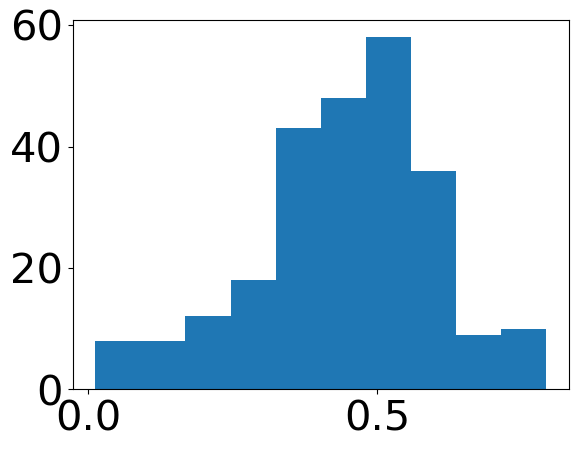

In [522]:
plt.hist(corr_naive)


In [523]:
adata.obs.loc[df_prediction_sub.index,:]

,pxl_row_in_fullres,pxl_col_in_fullres,id,array_row,array_col,lab,tumor,in_tissue,RPS3_pred_vit,IGLL5_pred_vit,...,COX4I1_pred_naive,PFDN5_pred_naive,SPARC_pred_naive,ISG15_pred_naive,EIF5A_pred_naive,__ambiguous[ENSG00000177576+ENSG00000265681+ENSG00000215472]_pred_naive,FXYD3_pred_naive,UBE2M_pred_naive,COL6A2_pred_naive,CHCHD2_pred_naive
coords,,,,,,,,,,,,,,,,,,,,,
7x16,1726.576,4347.556,7x16,7,16,L46,non,1,1.561284,1.748119,...,0.657143,0.816327,0.881633,0.126531,0.665306,0.526531,0.710204,0.546939,0.832653,0.522449
4x14,849.339,3766.572,4x14,4,14,L17,non,1,1.561580,1.748518,...,0.657143,0.816327,0.881633,0.126531,0.665306,0.526531,0.710204,0.546939,0.832653,0.522449
5x15,1139.387,4075.248,5x15,5,15,L37,non,1,1.564957,1.752612,...,0.657143,0.816327,0.881633,0.126531,0.665306,0.526531,0.710204,0.546939,0.832653,0.522449
4x13,844.952,3475.666,4x13,4,13,L6,non,1,1.562580,1.749709,...,0.657143,0.816327,0.881633,0.126531,0.665306,0.526531,0.710204,0.546939,0.832653,0.522449
8x19,2018.756,5216.088,8x19,8,19,L90,non,1,1.562806,1.750136,...,0.657143,0.816327,0.881633,0.126531,0.665306,0.526531,0.710204,0.546939,0.832653,0.522449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21x31,5807.793,8703.765,21x31,21,31,L290,tumor,1,2.319587,2.115218,...,2.415730,2.348315,2.921348,0.146067,3.505618,2.269663,4.056180,3.157303,1.730337,3.134831
23x28,6417.286,7852.577,23x28,23,28,L247,tumor,1,2.476750,2.699751,...,2.415730,2.348315,2.921348,0.146067,3.505618,2.269663,4.056180,3.157303,1.730337,3.134831
20x26,5543.398,7250.538,20x26,20,26,L193,tumor,1,2.482722,2.543224,...,2.415730,2.348315,2.921348,0.146067,3.505618,2.269663,4.056180,3.157303,1.730337,3.134831


In [524]:
df_prediction_sub

,RPS3_pred_vit,IGLL5_pred_vit,RPLP1_pred_vit,TFF3_pred_vit,TMSB10_pred_vit,RPS18_pred_vit,GAPDH_pred_vit,RPLP2_pred_vit,RPL37A_pred_vit,RPS14_pred_vit,...,COX4I1_pred_vit,PFDN5_pred_vit,SPARC_pred_vit,ISG15_pred_vit,EIF5A_pred_vit,__ambiguous[ENSG00000177576+ENSG00000265681+ENSG00000215472]_pred_vit,FXYD3_pred_vit,UBE2M_pred_vit,COL6A2_pred_vit,CHCHD2_pred_vit
coords,,,,,,,,,,,,,,,,,,,,,
7x16,1.561284,1.748119,2.265314,0.790651,1.983364,2.034666,1.992377,2.092112,1.834047,1.934662,...,0.573186,0.704038,0.666126,0.510604,0.545913,0.450761,0.507469,0.553966,0.800622,0.542944
4x14,1.561580,1.748518,2.265743,0.790779,1.983814,2.035062,1.992764,2.092533,1.834418,1.935105,...,0.573268,0.704207,0.666335,0.510719,0.546026,0.450761,0.507613,0.554040,0.800868,0.543022
5x15,1.564957,1.752612,2.270572,0.792775,1.988744,2.039507,1.997090,2.097182,1.838411,1.939580,...,0.574448,0.705833,0.668423,0.512163,0.547378,0.451488,0.509370,0.555541,0.803079,0.544002
4x13,1.562580,1.749709,2.267073,0.791391,1.985187,2.036315,1.994030,2.093809,1.835574,1.936312,...,0.573686,0.704653,0.666878,0.511146,0.546504,0.451165,0.508161,0.554551,0.801417,0.543427
8x19,1.562806,1.750136,2.267631,0.791518,1.985661,2.036805,1.994393,2.094415,1.835913,1.936813,...,0.573666,0.704819,0.667110,0.511259,0.546488,0.450954,0.508187,0.554607,0.801754,0.543353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21x31,2.319587,2.115218,2.850107,0.970180,2.460660,2.640563,2.733375,2.618298,2.655633,2.352972,...,0.936307,0.690928,0.825484,0.656361,0.970608,1.180080,0.625070,0.893006,0.703848,1.130711
23x28,2.476750,2.699751,3.086383,1.307324,2.914170,2.913756,3.006458,2.910540,2.770647,2.731619,...,1.094685,0.984127,0.917079,0.925277,1.089336,1.126511,0.923585,1.089707,0.852611,1.097409
20x26,2.482722,2.543224,3.051354,1.214595,2.779873,2.862745,2.952681,2.856799,2.781430,2.641522,...,1.066386,0.882086,0.874588,0.838904,1.076647,1.192578,0.824726,1.056757,0.775484,1.135615


(array([ 1.,  1.,  6.,  5., 14., 32., 53., 78., 49., 11.]),
 array([-0.20521033, -0.12564884, -0.04608735,  0.03347414,  0.11303563,
         0.19259712,  0.27215861,  0.3517201 ,  0.43128159,  0.51084308,
         0.59040457]),
 <BarContainer object of 10 artists>)

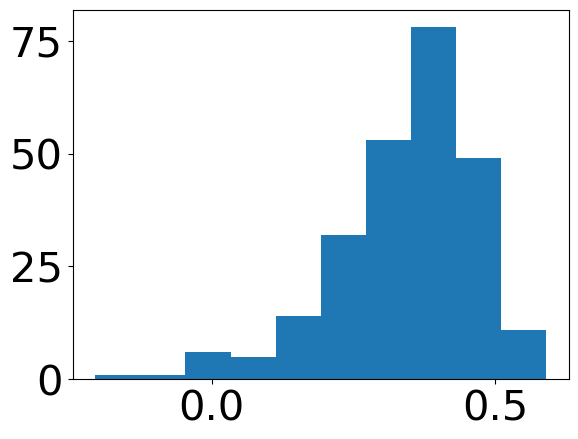

In [525]:
plt.hist(corr_vit)

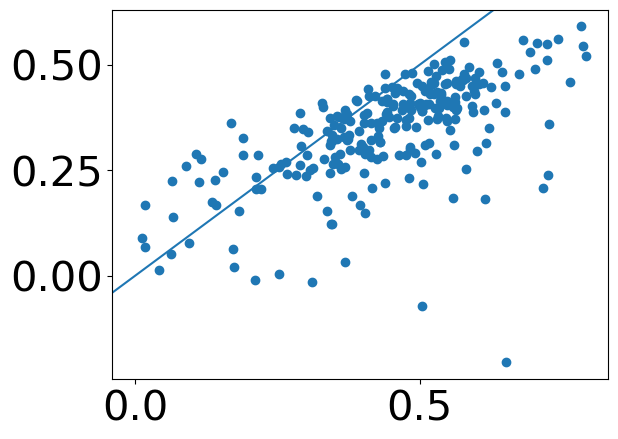

In [526]:
plt.scatter(corr_naive, corr_vit)
plt.axline((0, 0), slope=1)

In [527]:
# sc.pp.filter_cells(adata, min_counts = 5000)
# print(f'Number of cells after min count filter: {adata.n_obs}')
# sc.pp.filter_cells(adata, max_counts = 130000)
# print(f'Number of cells after max count filter: {adata.n_obs}')
# sc.pp.filter_cells(adata, min_genes = 3000)
# print(f'Number of cells after gene filter: {adata.n_obs}')
# sc.pp.filter_genes(adata, min_cells=10)
# print(f'Number of genes after cell filter: {adata.n_vars}')

In [528]:
# sc.pp.normalize_total(adata, inplace = True)
# #sc.pp.log1p(adata)
# sc.pp.highly_variable_genes(adata, flavor='seurat', n_top_genes=2000, inplace=True)

In [529]:
# sc.pp.pca(adata, n_comps=500, use_highly_variable=True, svd_solver='arpack')
# sc.pp.neighbors(adata)

# sc.tl.umap(adata)
# sc.tl.louvain(adata, key_added='clusters', resolution = 1)

In [530]:
# umap_coords = pd.DataFrame(adata.obsm['X_umap'])
# umap_coords.index = adata.obs.clusters.index
# umap_coords

# #umap_coords.to_csv(ResultsDir+'/umap_coords_C1D1.csv')

In [531]:
# sc.pl.umap(adata, color=['total_counts', 'n_genes_by_counts'])
# sc.pl.umap(adata, color='clusters', palette=sc.pl.palettes.default_20)


In [532]:
# adata.obs['clusters'] = adata.obs.clusters[adata.obs.index.map(str)].values #otherwise index not match, na
# sc.pl.spatial(adata, img_key = "hires", color="clusters", size=1, spot_size = 200, scale_factor = 1, crop_coord=[0, 9000, 0, 9000])



In [533]:
#plt.imshow(adata.uns["spatial"]['BC23287_C1']['images']['hires'])


In [534]:
# adata.X

In [535]:
#adata.obs.clusters.to_csv(ResultsDir+'/umap_cluster_C1D1_c'+str(num_clust)+'.csv')

In [536]:
#sc.pl.spatial(adata, img_key = "hires",color=['total_counts', 'n_genes_by_counts'])


In [537]:
#sc.pl.spatial(adata, img_key = "hires", color="clusters", groups = ["4","5"], crop_coord = [5000,8000,10000,15000], alpha = .5, size = 1.3)


In [538]:
# markers = pd.read_csv('markers_PDAC.csv', header=None).iloc[:,0]
# markers = markers[markers.isin(adata.var.index)]
# sub_adata = adata[:,markers]
# #sub_adata.X = (sub_adata.X - sub_adata.X.mean())/sub_adata.X.std()
# #
# #sc.pp.log1p(sub_adata)
# #sc.pp.scale(sub_adata)

# sc.tl.rank_genes_groups(sub_adata, "clusters", inplace = True)
# sc.pl.rank_genes_groups_heatmap(sub_adata, groupby = "clusters", show = True,
#                                 standard_scale = 'var',
#                                 var_names = markers, dendrogram =False, show_gene_labels=True)



In [539]:
# sub_adata.X

In [540]:
plt.subplots_adjust??

In [541]:
sc.pl.spatial??